In [3]:
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import statistics
import random


In [4]:
dev = pd.read_csv('hw2_data.csv')
#print(dev.columns)
#delete name column and add column of just ones

dev = dev.drop(["name"],axis = 1)

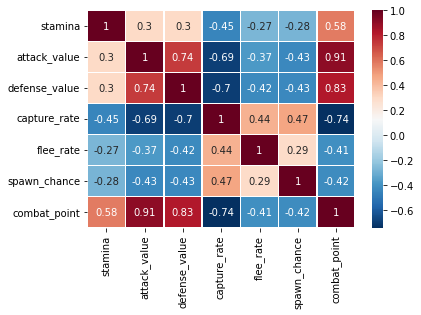

In [5]:
pearsoncorr = dev.corr(method='pearson')
sb.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

In [6]:
#add constant column for lin reg and lin percep
dev['constant'] = 1

def splitIntoFolds(dev):
# #split it into folds
  n = 5
  divider = len(dev)//5
  counter = 0
  split_sets = [None]*n
  for i in range(n):
    split_sets[i] = dev.loc[counter:min(len(dev),counter+divider)]
    counter += divider

  #make train sets and test sets
  train_sets = [None]*n
  test_sets = [None]*n
  for i in range(n):
    train_sets[i] = pd.concat([split_sets[x] for x in range(len(split_sets)) if x != i])
    test_sets[i] = split_sets[i]
  return (train_sets,test_sets)

#computes RSS using training data, applies to test data and returns residual sum of squares
def computeRSS(train_input,y_train,test_input,y_test):
  # get weights using w∗= (XT X)−1XT y.
  tb_inv = train_input.T.dot(train_input) 
  df_inv = pd.DataFrame(np.linalg.pinv(tb_inv.values), tb_inv.columns, tb_inv.index)
  final = (df_inv.dot(train_input.T)).dot(y_train)
 
  rss = 0
  
  for i in range(len(test_input)):
    test_row = test_input.iloc[i]
    error = (y_test.iloc[i]-test_row.dot(final))**2
    rss += error
  return rss

#takes in a train_set and test_set and splits it into feature sets (train_input and test_input)
#and output sets (y_train and y_test), takes outputCol to determine which column is used for output sets
def getInputOutput(train_set,test_set,outputCol):
  train_data = train_set
  train_input = train_data.drop([outputCol],axis=1) 
  y_train = train_data[[outputCol]]
  test_data = test_set 
  test_input = test_data.drop([outputCol],axis=1)   
  y_test = test_data[[outputCol]]
  return (train_input,y_train,test_input,y_test)

#linear regression for all folds
def totalRSSError(keep=None):  
  errors = []
  for i in range(5): #iterate through each fold
    train_input,y_train,test_input,y_test = getInputOutput(train_sets[i],test_sets[i],'combat_point')
    if keep != None:
      train_input = train_input[keep]
      test_input = test_input[keep]
    error = computeRSS(train_input,y_train,test_input,y_test)
    errors.append(error.iloc[len(error)-1]**(1/2))
  if keep != None:
    print(keep,": ",errors)
  else:
    print("All: ",errors)
  #print("Average sqrt RSS's: ", statistics.mean(errors) )
  return statistics.mean(errors)

#split into folds
train_sets,test_sets = splitIntoFolds(dev)

#linear regression test cases
print("All: ",totalRSSError(None))
print(["stamina","attack_value"],"average: ",totalRSSError(["stamina","attack_value"]))
print(["stamina","defense_value"],"average: ",totalRSSError(["stamina","defense_value"]))
print(["stamina","defense_value","attack_value"],"average: ",totalRSSError(["stamina","defense_value","attack_value"]))
print(["defense_value","attack_value"],"average: ",totalRSSError(["defense_value","attack_value"]))
print(["attack_value"],"average: ",totalRSSError(["attack_value"]))
print(["defense_value"],"average: ",totalRSSError(["defense_value"]))
print(["capture_rate","flee_rate","attack_value"],"average: ",totalRSSError(["capture_rate","flee_rate","attack_value"]))
print(["capture_rate","attack_value"],"average: ",totalRSSError(["capture_rate","attack_value"]))


All:  [1167.5167379751215, 368.4866962082428, 1114.57572735624, 1523.652783499694, 883.317130199987]
All:  1011.509815047857
['stamina', 'attack_value'] :  [1526.8346452166104, 1657.1141531789694, 1727.509087170134, 2264.97146869823, 1977.3850720635548]
['stamina', 'attack_value'] average:  1830.7628852654998
['stamina', 'defense_value'] :  [1753.8748667916507, 1733.9202776763098, 1853.4620013101503, 3163.7113376080897, 2429.7266479778245]
['stamina', 'defense_value'] average:  2186.9390262728048
['stamina', 'defense_value', 'attack_value'] :  [1532.0202903290085, 1635.9259116186163, 1699.9850879751034, 2247.771711194313, 2049.3277081290144]
['stamina', 'defense_value', 'attack_value'] average:  1833.0061418492112
['defense_value', 'attack_value'] :  [1515.212463337354, 1774.824436344692, 1864.0919138928027, 1753.8598773724586, 2385.938544466728]
['defense_value', 'attack_value'] average:  1858.7854470828072
['attack_value'] :  [1523.7671541619202, 1775.6430069862768, 1968.712893454033

In [7]:
#linear perceptron

#make copy of dev, add class column, remove combat_point
def binarize(dev):
  percep = dev.copy()
  mean = percep["combat_point"].mean()
  percep["class"] = 1 
  percep.loc[percep["combat_point"] < mean, "class"] = -1
  percep=percep.drop(["combat_point"], axis = 1)
  cols = len(percep.columns)
  w = pd.DataFrame(columns = percep.columns)
  w=w.drop(["class"], axis = 1)
  w.loc[len(w.index)] = [1]*len(w.columns)
  print(w)
  return (percep,w)
  
#find correctly and incorrectly identified given feature set and output set
def perceptronSplit(w,input,output):
  correct = []
  incorrect = []
  for i in range(len(input)):
    #print(output.head())
    x_row = input.iloc[i]
    Class = output.iloc[i].iloc[0]
    #print(w,x_row)
    h = w.dot(x_row).iloc[0]
    #print(h,Class==-1)
    
    if h >= 0:
      if Class == 1:
        correct.append((x_row,Class))
      else:
        incorrect.append((x_row,Class))
    else:
      if Class == 1:
        incorrect.append((x_row,Class))
      else:
        correct.append((x_row,Class))
  return (correct,incorrect)


def perceptron(w,train_input,y_train,test_input,y_test,iterations):
  correct,incorrect = [],[]
  for i in range(iterations):
    
    if i != 0:
      #I stop algorithm when the error is 25% or less or a specifc number of iterations
      #this is because data is not linearly separable, after each iteration it is not guaranteed for the error to get better
      if len(correct)/len(incorrect) >= 3:
        break
      mistake,mistakeClass = random.choice(incorrect)
      w = w+ (mistakeClass)*mistake
    correct,incorrect = perceptronSplit(w,train_input,y_train)
  tst_correct,tst_incorrect = perceptronSplit(w,test_input,y_test)
  print("test perceptron error",len(test_input), len(tst_correct),len(tst_incorrect))
  return len(tst_incorrect)/len(test_input)  

def totalpercep(keep=None):
  percep,w = binarize(dev)
  train_sets,test_sets = splitIntoFolds(percep)
  errors = []
  #linear perceptron algorithm for all five folds
  for i in range(5):      
    train_input,y_train,test_input,y_test = getInputOutput(train_sets[i],test_sets[i],"class")
    error = perceptron(w,train_input,y_train,test_input,y_test,25)
    errors.append(error)
  print(errors)
  print("Average perceptrons ", statistics.mean(errors) )
  return statistics.mean(errors)

print("All: ",totalpercep())

  stamina attack_value defense_value capture_rate flee_rate spawn_chance  \
0       1            1             1            1         1            1   

  constant  
0        1  
test perceptron error 30 20 10
test perceptron error 30 25 5
test perceptron error 30 25 5
test perceptron error 30 23 7
test perceptron error 30 24 6
[0.3333333333333333, 0.16666666666666666, 0.16666666666666666, 0.23333333333333334, 0.2]
Average perceptrons  0.22
All:  0.22
